In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import tensorflow as tf
rand_state = np.random.randint(0, 100)
tf.set_random_seed(rand_state)
np.random.seed(rand_state)

from skimage import exposure
import cv2
import glob
import time
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


# Introduction  

"What would you say if I told you there is a app on the market that tell you if you have a hotdog or not a hotdog. It is very good and I do not want to work on it any more. You can hire someone else." - Jian-Yang, [Silicon Valley](https://www.youtube.com/watch?v=ACmydtFDTGs)

Sounds simple enough, right? It's actually a little more complex, referring to the theory behind convolutional neural networks (CNN) and their applications in image classification. However, Keras makes it relatively easy to setup and evaluate a CNN!  

The objective of this project is simple: given a picture, does it contain a hot dog or not?

## Data

This data was extracted from the Food 101 dataset. A full version of the dataset is available [here](https://www.kaggle.com/dansbecker/food-101). This is a binary classification task, while not very interesting a similar approach can be taken to extend this to multiple food categories. Note that multiple terms can refer to what is essentially the same object, in this case the difference appears to primarily be regional: a frankfurter, wienerwurst or hot dog. Thanks to [DanB](https://www.kaggle.com/dansbecker) for extracting the dataset ([kaggle](https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog)) 

To simplify this project, the data is completely balanced: 50% hot dog images and 50% not hot dog images. We will then use 498 images to train our model, and 500 labeled images to test it on.

**Data augmentation**:  
Neural networks perform much better when fed large amounts of data, and we only have 500 images for each class. We could just download more images from a source like ImageNet, but I will just augment this data set: add random rotation and or blur to our existing images to get 10,000 images for each class.

In [2]:
def rotateImage(img, angle):
    (rows, cols, ch) = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    return cv2.warpAffine(img, M, (cols,rows))
    
    
def loadBlurImg(path, imgSize):
    img = cv2.imread(path)
    angle = np.random.randint(0, 360)
    img = rotateImage(img, angle)
    img = cv2.blur(img,(5,5))
    img = cv2.resize(img, imgSize)
    return img

def loadImgClass(classPath, classLable, classSize, imgSize):
    x = []
    y = []
    
    for path in classPath:
        img = loadBlurImg(path, imgSize)        
        x.append(img)
        y.append(classLable)
        
    while len(x) < classSize:
        randIdx = np.random.randint(0, len(classPath))
        img = loadBlurImg(classPath[randIdx], imgSize)
        x.append(img)
        y.append(classLable)
        
    return x, y

def loadData(img_size, classSize):
    hotdogs = glob.glob('./hotdog/**/*.jpg', recursive=True)
    notHotdogs = glob.glob('./not-hotdog/**/*.jpg', recursive=True)
    
    
    imgSize = (img_size, img_size)
    xHotdog, yHotdog = loadImgClass(hotdogs, 0, classSize, imgSize)
    xNotHotdog, yNotHotdog = loadImgClass(notHotdogs, 1, classSize, imgSize)
    print("There are", len(xHotdog), "hotdog images")
    print("There are", len(xNotHotdog), "not hotdog images")
    
    X = np.array(xHotdog + xNotHotdog)
    y = np.array(yHotdog + yNotHotdog)
    
    return X, y

Normalization and histogram [equalization](https://en.wikipedia.org/wiki/Histogram_equalization)

In [3]:
def toGray(images):
    # rgb2gray converts RGB values to grayscale values by forming a weighted sum of the R, G, and B components:
    # 0.2989 * R + 0.5870 * G + 0.1140 * B 
    # source: https://www.mathworks.com/help/matlab/ref/rgb2gray.html
    
    images = 0.2989*images[:,:,:,0] + 0.5870*images[:,:,:,1] + 0.1140*images[:,:,:,2]
    return images

def normalizeImages(images):
    # use Histogram equalization to get a better range
    # source http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist
    images = (images / 255.).astype(np.float32)
    
    for i in range(images.shape[0]):
        images[i] = exposure.equalize_hist(images[i])
    
    images = images.reshape(images.shape + (1,)) 
    return images

def preprocessData(images):
    grayImages = toGray(images)
    return normalizeImages(grayImages)

In [15]:
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

size = 128
classSize = 10000
'''
I saved the transformed images (of size 20000,128,128,1) so I do not have to recreate it

scaled_X, y = loadData(size, classSize)
scaled_X = preprocessData(scaled_X)
scaled_X.tofile('scaled_X.dat')
'''
scaled_X, y = loadData(size, classSize)
scaled_X = preprocessData(scaled_X)
y = to_categorical(y)
#y.tofile('y.dat')

# scaled_X = np.fromfile('scaled_X.dat', dtype=float)
# scaled_X = scaled_X.reshape((classSize,size,size,1))


# y = np.fromfile('y.dat', dtype=float)
n_classes=2
print("y shape", y.shape)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                    test_size=0.2, 
                                                    random_state=rand_state)

print("train shape X", X_train.shape)
print("train shape y", y_train.shape)
print("Test shape X:", X_test.shape)
print("Test shape y: ", y_test.shape)

inputShape = (size, size, 1)

There are 10000 hotdog images
There are 10000 not hotdog images
y shape (20000, 2)
train shape X (16000, 128, 128, 1)
train shape y (16000, 2)
Test shape X: (4000, 128, 128, 1)
Test shape y:  (4000, 2)


In [16]:
# Change shape 
# Note that our images are 128*128 pixels, so in reshaping to arrays we want
# 4,000 arrays of length 16384, one for each image
X_train_reshaped = X_train.reshape(X_train.shape[0], 16384)
X_test_reshaped = X_test.reshape(X_test.shape[0], 16384)

# Print sample sizes
print(X_train_reshaped.shape[0], 'train samples')
print(X_test_reshaped.shape[0], 'test samples')

16000 train samples
4000 test samples


In [17]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Models  

## Multi Layer Perceptron  
_Feedforward neural network_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 256)               4194560   
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 514       
Total params: 4,260,866
Trainable params: 4,260,866
Non-trainable params: 0
_________________________________________________________________
Execution time: 506.10870909690857



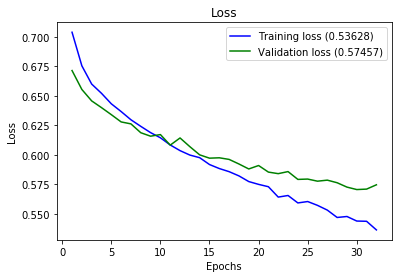

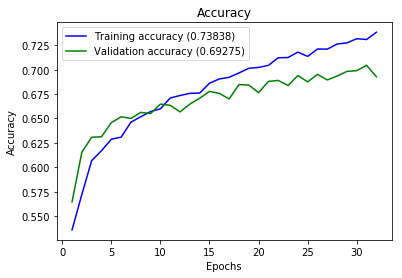

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

start = time.time()
# Start with a simple sequential model
model_1 = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model_1.add(Dense(256, activation='relu', input_shape=(16384,)))
# Dropout layers remove features and fight overfitting
model_1.add(Dropout(0.2))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.2))
# End with a number of units equal to the number of classes we have for our outcome
model_1.add(Dense(2, activation='softmax'))

model_1.summary()

# Set callback functions to early stop training and save the best model so far
callbacks_1 = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='model_1.h5', monitor='val_acc', save_best_only=True)]

# Compile the model to put it all together.
model_1.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=1e-5),
              metrics=['accuracy'])

history_1 = model_1.fit(X_train_reshaped, y_train,
                      batch_size=32,
                      epochs=50,
                      callbacks=callbacks_1,
                      verbose=0, 
                      validation_data=(X_test_reshaped, y_test))

end = time.time()
print("Execution time: {}\n".format(end-start))

plot_history(history_1)

With early stopping (max of 50), our best model comes at 32 epochs where we achieve an accuracy of **69.27**%. The model does appear to start significantly overfitting until epoch 15. Increase the dropout value? Add regularization? 

## Convolutional Neural Network (CNN)

In [30]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

#input image dimensions
img_rows, img_cols = 128, 128

model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=inputShape))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(Dropout(0.4))
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(2, activation='softmax'))

model_2.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

start = time.time()

model_2.summary()
# Set callback functions to early stop training and save the best model so far
callbacks_2 = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='model_2.h5', monitor='val_acc', save_best_only=True)]

history_2 = model_2.fit(X_train, y_train,
                      batch_size=24,
                      epochs=20, 
                      callbacks=callbacks_2,
                      verbose=0,
                      validation_data=(X_test, y_test))

end = time.time()
print('Execution time: ', end-start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 128)       73856     
__________

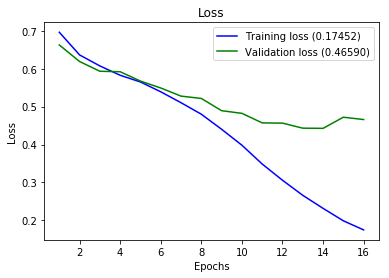

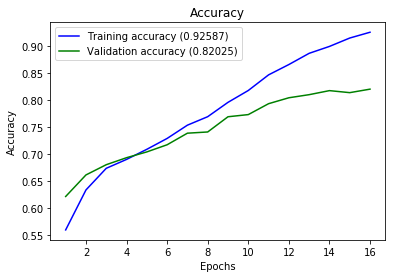

In [31]:
plot_history(history_2)

As I mentioned previously, it is not clear to me how you design a network architecture so I "borrowed" the one used [here](https://www.kaggle.com/bugraokcu/cnn-with-keras) (Fashio-MNIST dataset). I did tune the model:
  1. [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) optimization algorithm
  2. learning rate to 0.0001
  3. Initialize weights using [He Normal](https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528)
  4. early stopping

Our final model was at epoch 16 and achieved **82**% accuracy on the test set! However, after epoch 8 we see our model starts to significantly overfit the train data. We could try adding regularization to our layers ([here](https://machinelearningmastery.com/how-to-reduce-generalization-error-in-deep-neural-networks-with-activity-regularization-in-keras/)), however this model took 1:47 to run so I will leave that for later :)

## Hierarchical Recurrrent Neural Network

In [25]:
from keras.layers import Input, TimeDistributed, LSTM
from keras.models import Model
from keras import regularizers


# Embedding dimensions.
row_hidden = 128
col_hidden = 128

row, col, pixel = X_train.shape[1:]

# 4D input.
x = Input(shape=(row, col, pixel))

lstm = LSTM(row_hidden,kernel_initializer='he_normal')

# Encodes a row of pixels using TimeDistributed Wrapper.
encoded_rows = TimeDistributed(lstm)(x)

# Encodes columns of encoded rows.
encoded_columns = LSTM(col_hidden)(encoded_rows)

# Final predictions and model.
prediction = Dense(2, activation='softmax')(encoded_columns)
model_3 = Model(x, prediction)

model_3.summary()

model_3.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 128, 128)          66560     
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 198,402
Trainable params: 198,402
Non-trainable params: 0
_________________________________________________________________


In [26]:
start = time.time()

callbacks_3 = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='model_3.h5', monitor='val_acc', save_best_only=True)]

# Training.
history_3 = model_3.fit(X_train, y_train,
                        batch_size=32,
                        epochs=3,
                        callbacks=callbacks_3,
                        verbose=1,
                        validation_data=(X_test, y_test))

end = time.time()
print('Execution time: ', end-start)

Train on 16000 samples, validate on 4000 samples
Epoch 1/3
16000/16000 [==============================] - 2060s 129ms/step - loss: 0.6726 - acc: 0.5907 - val_loss: 0.6340 - val_acc: 0.6365
Epoch 2/3
16000/16000 [==============================] - 2068s 129ms/step - loss: 0.6376 - acc: 0.6369 - val_loss: 0.6464 - val_acc: 0.6538
Epoch 3/3
16000/16000 [==============================] - 2097s 131ms/step - loss: 0.6179 - acc: 0.6608 - val_loss: 0.6042 - val_acc: 0.6847
Execution time:  6227.856939077377


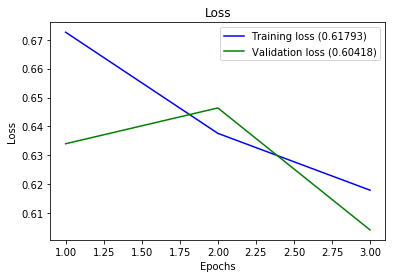

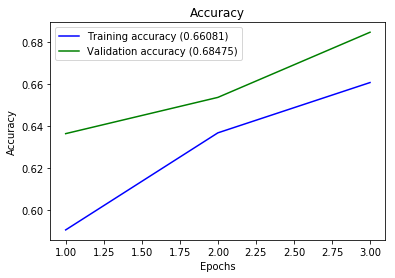

In [27]:
plot_history(history_3)

This model takes much longer to train than our MLP and was less accurate; it appears that this model was not "learning" very quickly, so increasing the learning rate (optimizer) or changing how weights are initialized might help with this. 

# Conclusion  

So with the right hyper-parameters you can get a MLP, CNN or LSTM fairly accurate on the limited amount of data we had. However, the CNN achieved the highest accuracy of **82%** on the test set, but also began to badly overfit the train data with an accuracy of 92%. This problem can be minimized via adding regularization to the convolution layers, and/or getting more labeled training data. Running time should also be considered, the CNN took 107.3 minutes to train, the MLP took just 8.4 minutes and the LSTM model took 103.8 minutes.  

So convolutional neural networks appears the way to go when dealing with raw images. Note that the preprocessing (converting to grayscale and normalizing are important). My reading suggests starting or using a pre-trained network, which PyTorch makes (relatively) simple to implement networks such as ResNet, YOLO or VGG16. I will leave this task for my final capstone.  